### 1. Import necessary packages and set problem specific data
This code runs with TensorFlow version `2.3.0`.
The implementation relies mainly on the scientific computing library [NumPy](https://numpy.org/doc/stable/user/whatisnumpy.html) and the machine learning library [TensorFlow](https://www.tensorflow.org/).

In [1]:
# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np

# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

# Set constants
pi = tf.constant(np.pi, dtype=DTYPE)
#viscosity = .01/pi

# Define initial condition
def fun_u_0(x):
    return 0.0*x[:,0] #tf.sin(pi * x[:,0]) * tf.sin(pi * x[:,1])

# Define boundary condition
def fun_u_b(t, x):
    n = x.shape[0]
    return tf.zeros((n,1), dtype=DTYPE)

# Define residual of the PDE
def fun_r(t, x1, u, u_t, u_x1,u_x1x1):
    return u_t - u_x1x1

def fun_nb1(t, u_x1):

    D = 1.0
    timethreshold = 0.5
    flux = 100

#    bccenter1 = (t>=0.0)&(t<timethreshold)
#    bccenter2 = (t>=timethreshold)
    
    #loss_nb = tf.reduce_sum(tf.square(u_x1[bccenter1] + t[bccenter1] * flux * timethreshold))
    #loss_nb += tf.reduce_sum(tf.square(u_x1[bccenter2] + flux))
            
    return u_x1 + t * flux

def fun_nb2(u_x1):
        
    return u_x1

### 2. Generate a set of collocation points

We assume that the collocation points $X_r$ as well as the points for the initial time and boundary data $X_0$ and $X_b$ are generated by random sampling from a uniform distribution.
Although uniformly distributed data are sufficient in our experiments, the authors of
([Raissi et al., 2017 (Part I)](https://arxiv.org/abs/1711.10561))
employed a space-filling Latin hypercube sampling strategy ([Stein, 1987](https://www.tandfonline.com/doi/abs/10.1080/00401706.1987.10488205)).
Our numerical experiments indicate that this strategy slightly improves the observed convergence rate, but for simplicity the code examples accompanying this paper employ uniform sampling throughout.
We choose training data of size $N_0 = 2500, $N_b =50$ and $N_f=10000$.

In [2]:
# Set number of data points
N_0 = 10000
N_db = 100
N_nb1 = 100
N_nb2 = 100
N_r = 10000

# Set boundary
tmin = 0.
tmax = 1.

x1min = 0.
x1max = 1.

x2min = 0.
x2max = 1.

# Lower bounds
lb = tf.constant([tmin, x1min], dtype=DTYPE)
# Upper bounds
ub = tf.constant([tmax, x1max], dtype=DTYPE)

# Set random seed for reproducible results
tf.random.set_seed(0)

# Draw uniform sample points for initial boundary data
t_0 = tf.ones((N_0,1), dtype=DTYPE)*lb[0]
x_0 = tf.random.uniform((N_0,1), lb[1], ub[1], dtype=DTYPE)
X_0 = tf.concat([t_0, x_0], axis=1)

# Evaluate intitial condition at x_0
u_0 = fun_u_0(x_0)
print(u_0)

tf.Tensor([0. 0. 0. ... 0. 0. 0.], shape=(10000,), dtype=float32)


In [7]:
#t_db = tf.random.uniform((N_db,1), lb[0], ub[0], dtype=DTYPE)
#x_db = tf.ones((N_db,1), dtype=DTYPE)*ub[1]
#X_db = tf.concat([t_db, x_db], axis=1)
#u_db = fun_u_b(t_db, x_db)

t_nb1 = tf.random.uniform((N_nb1,1), lb[0], ub[0], dtype=DTYPE)
x_nb1 = tf.ones((N_nb1,1), dtype=DTYPE)*lb[1]
X_nb1 = tf.concat([t_nb1, x_nb1], axis=1)

t_nb2 = tf.random.uniform((N_nb2,1), lb[0], ub[0], dtype=DTYPE)
x_nb2 = tf.ones((N_nb2,1), dtype=DTYPE)*ub[1]
X_nb2 = tf.concat([t_nb2, x_nb2], axis=1)

t_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
x_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
X_r = tf.concat([tf.concat([t_r, x_r], axis=1),X_nb1, X_nb2],axis=0)

# Collect boundary and inital data in lists
#X_data = [X_0, X_db, X_nb]
#u_data = [u_0, u_db]

X_data = [X_0, X_nb1, X_nb2]
u_data = u_0

Positions of collocation points.

C:\Users\zimu2\AppData\Local\Temp\ipykernel_12000\3007481556.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X_r[:,0],X_r[:,1],cmap='viridis')


Text(0, 0.5, '$x$')

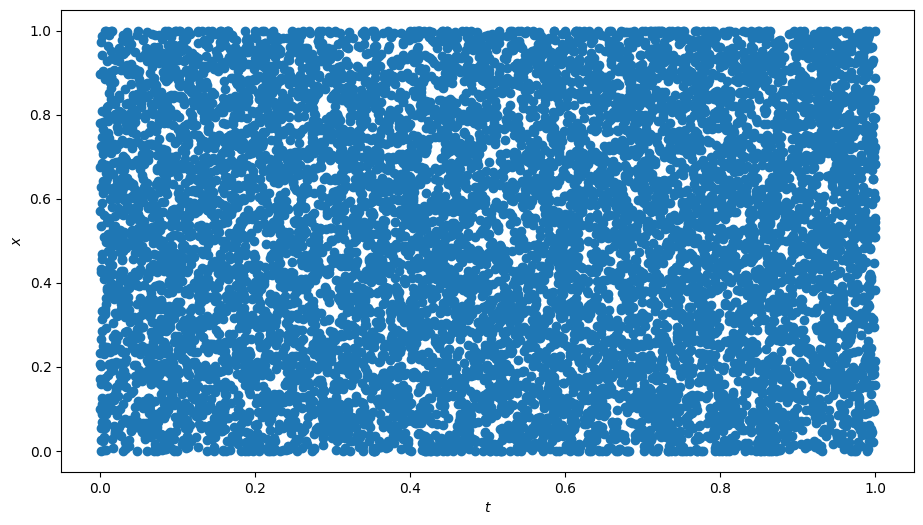

In [8]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(11,6))
#ax = fig.add_subplot(111, projection='3d')
ax = fig.add_subplot(111)
ax.scatter(X_r[:,0],X_r[:,1],cmap='viridis')
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')

### 3. Set up network architecture

In this example, adopted from 
([Raissi et al., 2017 (Part I)](https://arxiv.org/abs/1711.10561)), we assume a feedforward neural network of the following structure:
- the input is scaled elementwise to lie in the interval $[-1,1]$,
- followed by 8 fully connected layers each containing 20 neurons and each followed by a hyperbolic tangent activation function,
- one fully connected output layer.

This setting results in a network with $3021$ trainable parameters (first hidden layer: $2 \cdot 20 + 20 = 60$; seven intermediate layers: each $20 \cdot 20 + 20 = 420$; output layer: $20 \cdot 1 + 1 = 21$).

In [11]:
def init_model(num_hidden_layers=8, num_neurons_per_layer=40):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # Input is two-dimensional (time + one spatial dimension)
    model.add(tf.keras.Input(2))

    # Introduce a scaling layer to map input to [lb, ub]
    scaling_layer = tf.keras.layers.Lambda(
                #lambda x: 2.0*(x[0] - lb[1])/(ub[1] - lb[1]) - 1.0,2.0*(x[1] - lb[2])/(ub[2] - lb[2]) - 1.0)
                lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
    model.add(scaling_layer)

    # Append hidden layers
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('tanh'),
            kernel_initializer='glorot_normal'))

    # Output is one-dimensional
    model.add(tf.keras.layers.Dense(1))
    
    return model

### 4. Define routines to determine loss and gradient

In the following code cell, we define a function which evaluates the residual

$$
\begin{align}
    r_\theta (t,x) := \partial_t u_\theta (t,x) + \mathcal{N}[u_\theta] (t,x).
\end{align}
$$

of the nonlinear PDE in the points $X_r = \{(t^r_i,x^r_i)\}_{i=1}^{N_r}$.
To compute the necessary partial derivatives we use the automatic differentiation capabilities of TensorFlow.

For the Burgers equation, this entails computing $\partial_t u_\theta$, $\partial_x u_\theta$ and $\partial_{xx} u_\theta$.
In TensorFlow, this is done via a `GradientTape`, see also the [documentation](https://www.tensorflow.org/api_docs/python/tf/GradientTape), which keeps track of the `watched` variables, in our case `t` and `x`, in order to compute the derivatives.

In [12]:
def get_r(model, X_r, N_r, N_nb1):
    
    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        t, x1 = X_r[:, 0], X_r[:,1]

        # Variables t and x are watched during tape
        # to compute derivatives u_t and u_x
        tape.watch(t)
        tape.watch(x1)

        # Determine residual 
        u = model(tf.stack([t, x1], axis=1))

        # Compute gradient u_x within the GradientTape
        # since we need second derivatives
        u_x1 = tape.gradient(u, x1)
    
    u_t = tape.gradient(u, t)
    u_x1x1 = tape.gradient(u_x1, x1)
    
    del tape

    return fun_r(t, x1, u, u_t, u_x1, u_x1x1), \
            fun_nb1(t[N_r:N_r+N_nb1], u_x1[N_r:N_r+N_nb1]), fun_nb2(u_x1[N_r+N_nb1:])

The next function computes the loss for our model

$$
\begin{align}
    \phi_\theta(X) := \phi_\theta^r(X^r) + \phi_\theta^0(X^0) + \phi_\theta^b(X^b),
\end{align}
$$

as a function of our the training data.
The collocation points are given by `X_r`, the initial and boundary data is contained in `X_data = [X_0, X_b]` and `u_data = [u_0, u_b]`.

In [17]:
def compute_loss(model, X_r, X_data, u_data, lossratio, N_r, N_nb1):
    
    # Compute phi^r
    r,r_nb1,r_nb2 = get_r(model, X_r, N_r, N_nb1)
    phi_r = tf.reduce_mean(tf.square(r))
    phi_rnb1 = tf.reduce_mean(tf.square(r_nb1))
    phi_rnb2 = tf.reduce_mean(tf.square(r_nb2))
    
    # Initialize loss
    loss = phi_r
    loss_r = phi_r
    loss += phi_rnb1
    loss_rnb1 = phi_rnb1
    loss += phi_rnb2
    loss_rnb2 = phi_rnb2    
    
    # Add phi^0 & phi^b to the loss
    u_pred = model(X_data[0])
    loss += tf.reduce_mean(tf.square(u_data - u_pred))
    loss_0 = tf.reduce_mean(tf.square(u_data - u_pred))
    
    #u_pred = model(X_data[1])
    #loss += tf.reduce_mean(tf.square(u_data[1] - u_pred))
    #loss_db = tf.reduce_mean(tf.square(u_data[1] - u_pred))
    loss_db = 0.0
    
    return loss,loss_r,loss_rnb1,loss_rnb2,loss_0,loss_db

The next function computes the gradient of the loss function $\phi_\theta$ with respect to the unknown variables in the model, also called `trainable_variables` in TensorFlow, i.e. $\nabla_\theta \phi_\theta$.
This is also done via a `GradientTape`, but now it keeps track of the parameters $\theta$ in our model, which can be accessed by `model.trainable_variables`.

In [14]:
def get_grad(model, X_r, X_data, u_data, lossratio, N_r, N_nb1):
    
    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss,loss_r,loss_rnb1,loss_rnb2,loss_0,loss_db = compute_loss(model, X_r, X_data, u_data, lossratio, N_r, N_nb1)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss,g,loss_r,loss_rnb1,loss_rnb2,loss_0,loss_db

### 5. Set up optimizer and train model
Next we initialize the model, set the learning rate to the step function

$$
\delta(n) = 0.01 \, \textbf{1}_{\{n < 1000\}} + 0.001 \, \textbf{1}_{\{1000 \le n < 3000\}} + 0.0005 \, \textbf{1}_{\{3000 \le n\}}
$$

which decays in a piecewise constant fashion, and set up a `tf.keras.optimizer` to train the model.

In [15]:
# Initialize model aka u_\theta
model = init_model()

# We choose a piecewise decay of the learning rate, i.e., the
# step size in the gradient descent type algorithm
# the first 1000 steps use a learning rate of 0.01
# from 1000 - 3000: learning rate = 0.001
# from 3000 onwards: learning rate = 0.0005

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])

# Choose the optimizer, LBFGS
optim = tf.keras.optimizers.Adam(learning_rate=lr)

Train the model for $N=5000$ epochs (takes approximately 3 minutes).
Here, we set up a function `train_step()` which performs one training step.

*Note*: The `@tf.function` is a so-called `Decorator` within Python. This particular decorator redefines the function that follows, in our case `train_step`, as a TensorFlow graph which may speed up the training significantly.

In [18]:
from time import time

# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step():
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta,loss_r,loss_rnb1,loss_rnb2,loss_0,loss_db = get_grad(model, X_r, X_data, u_data, lossratio, N_r, N_nb1)
    
    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))
    
    return loss,loss_r,loss_rnb1,loss_rnb2,loss_0,loss_db

# Number of training epochs
N = 3000
lossratio = 1
hist = []
#nbcini = tf.Variable(tf.zeros((N_nb,1), dtype=DTYPE))

# Start timer
t0 = time()

for i in range(N+1):
    
    loss,loss_r,loss_rnb1,loss_rnb2,loss_0,loss_db = train_step()
    
    # Append current loss to hist
    hist.append(loss.numpy())
    
    # Output current loss after 50 iterates
    if i%50 == 0:
        print('It {:05d}: total loss = {:10.3e}'.format(i,loss))
        print('domain loss = {:10.3e}, nbc1 loss = {:10.3e}, nbc2 loss = {:10.3e}, initial loss = {:10.3e}, dbc loss = {:10.3e}'\
              .format(loss_r,loss_rnb1,loss_rnb2,loss_0,loss_db))
        
# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: total loss =  3.514e+03
domain loss =  1.305e-01, nbc1 loss =  3.514e+03, nbc2 loss =  2.776e-02, initial loss =  7.591e-03, dbc loss =  0.000e+00
It 00050: total loss =  1.834e+03
domain loss =  5.287e+02, nbc1 loss =  1.159e+03, nbc2 loss =  7.980e+00, initial loss =  1.379e+02, dbc loss =  0.000e+00
It 00100: total loss =  7.549e+02
domain loss =  1.848e+02, nbc1 loss =  3.782e+02, nbc2 loss =  6.521e+01, initial loss =  1.268e+02, dbc loss =  0.000e+00
It 00150: total loss =  5.635e+02
domain loss =  1.578e+02, nbc1 loss =  2.587e+02, nbc2 loss =  4.877e+01, initial loss =  9.817e+01, dbc loss =  0.000e+00
It 00200: total loss =  4.408e+02
domain loss =  5.510e+01, nbc1 loss =  3.188e+02, nbc2 loss =  3.055e+01, initial loss =  3.635e+01, dbc loss =  0.000e+00
It 00250: total loss =  1.128e+03
domain loss =  7.952e+02, nbc1 loss =  1.050e+02, nbc2 loss =  2.040e+02, initial loss =  2.349e+01, dbc loss =  0.000e+00
It 00300: total loss =  2.053e+02
domain loss =  3.171e+01

It 02650: total loss =  4.440e-01
domain loss =  1.417e-01, nbc1 loss =  2.565e-01, nbc2 loss =  2.844e-02, initial loss =  1.740e-02, dbc loss =  0.000e+00
It 02700: total loss =  4.312e-01
domain loss =  1.387e-01, nbc1 loss =  2.485e-01, nbc2 loss =  2.628e-02, initial loss =  1.771e-02, dbc loss =  0.000e+00
It 02750: total loss =  4.189e-01
domain loss =  1.357e-01, nbc1 loss =  2.410e-01, nbc2 loss =  2.426e-02, initial loss =  1.805e-02, dbc loss =  0.000e+00
It 02800: total loss =  4.071e-01
domain loss =  1.326e-01, nbc1 loss =  2.337e-01, nbc2 loss =  2.238e-02, initial loss =  1.841e-02, dbc loss =  0.000e+00
It 02850: total loss =  3.956e-01
domain loss =  1.294e-01, nbc1 loss =  2.268e-01, nbc2 loss =  2.063e-02, initial loss =  1.878e-02, dbc loss =  0.000e+00
It 02900: total loss =  3.846e-01
domain loss =  1.263e-01, nbc1 loss =  2.201e-01, nbc2 loss =  1.901e-02, initial loss =  1.916e-02, dbc loss =  0.000e+00
It 02950: total loss =  3.740e-01
domain loss =  1.231e-01

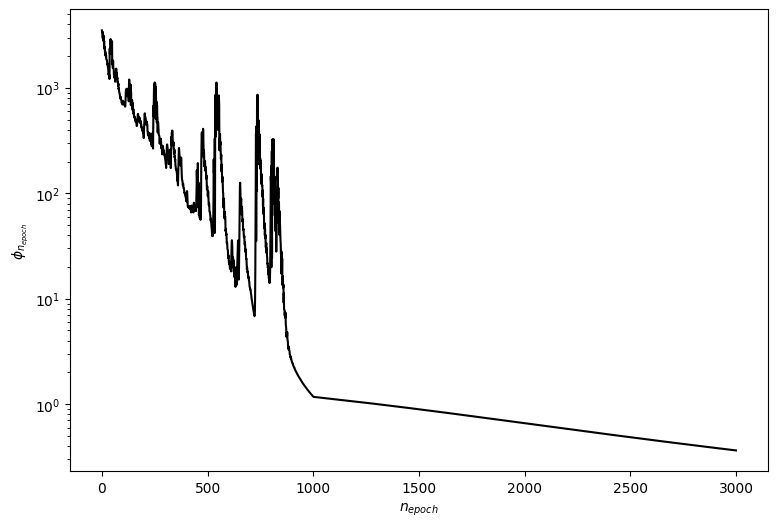

In [19]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(hist)), hist,'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$');

In [20]:
N = 100
time = 1.0
x1space = np.linspace(lb[1], ub[1], N + 1)
X1 = np.meshgrid(x1space)
Xgrid = np.vstack([np.ones(((N+1),), dtype=DTYPE) * time, X1]).T
upred = model(tf.cast(Xgrid,DTYPE))
# Reshape upred
U = upred.numpy().reshape(N+1)


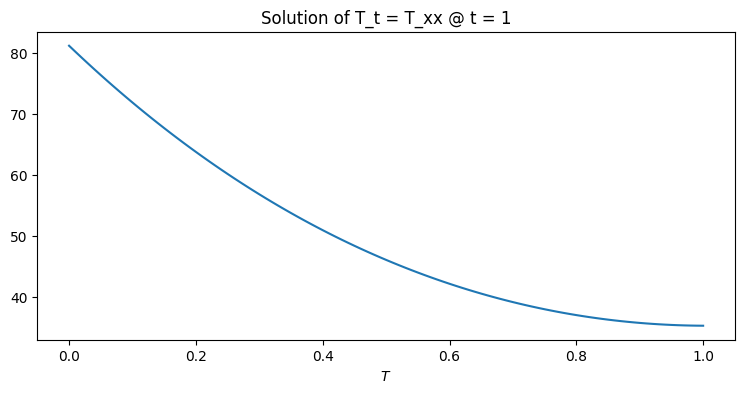

In [21]:
# Surface plot of solution u(t,x)
fig = plt.figure(figsize=(9,4))
ax = fig.add_subplot(111)
ax.plot(X1[0], U);
ax.set_xlabel('$x$')
ax.set_xlabel('$T$')
ax.set_title('Solution of T_t = T_xx @ t = 1');

In [22]:
model.save('saved_model/1DHeatTransferNaturalBC-flux100t')

INFO:tensorflow:Assets written to: saved_model/1DHeatTransferNaturalBC-flux100t\assets


In [23]:
np.save('1DHeatTransferNaturalBC-flux100t_TempProfile', [X1[0,:], U[0,:]])

TypeError: list indices must be integers or slices, not tuple

In [25]:
X1

[array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
        0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
        0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
        0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
        0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
        0.99, 1.  ])]